# Load packages

In [1]:
# Packages
import os, csv
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from nervaluate import Evaluator
import itertools
from IPython.display import display
from utils import preprocess_rater, list_overlap, average_score, rater_avg_df

# PREP FOR SCRIPT:

In [2]:
# # python src/load_docbin_as_jsonl.py data/DANSK/test.spacy blank:da --ner > data/DANSK/test.jsonl

# import spacy
# from spacy.tokens import DocBin

# def retrieve_doc_texts(docs):
#     return [d.text for d in docs]

# nlp = spacy.blank("da")
# docs = list(DocBin().from_disk("../data/DANSK/test.spacy").get_docs(nlp.vocab))
# nlp_ner_sm = spacy.load("da_dacy_small_ner_fine_grained")
# nlp_ner_md = spacy.load("da_dacy_medium_ner_fine_grained")
# nlp_ner_lg = spacy.load("da_dacy_large_ner_fine_grained")
# texts = retrieve_doc_texts(docs)

# sm_docs = [nlp_ner_sm(text) for text in texts]
# md_docs = [nlp_ner_md(text) for text in texts]
# lg_docs = [nlp_ner_lg(text) for text in texts]

# db = DocBin()
# outpath = "../output/predictions/sm.spacy"
# for doc in sm_docs:
#     db.add(doc)
# db.to_disk(outpath)

# db = DocBin()
# outpath = "../output/predictions/md.spacy"
# for doc in md_docs:
#     db.add(doc)
# db.to_disk(outpath)

# db = DocBin()
# outpath = "../output/predictions/lg.spacy"
# for doc in lg_docs:
#     db.add(doc)
# db.to_disk(outpath)

# # python src/load_docbin_as_jsonl.py output/predictions/sm.spacy blank:da --ner > output/predictions/sm.jsonl
# # python src/load_docbin_as_jsonl.py output/predictions/md.spacy blank:da --ner > output/predictions/md.jsonl
# # python src/load_docbin_as_jsonl.py output/predictions/lg.spacy blank:da --ner > output/predictions/lg.jsonl


# Load data and preprocess

In [3]:
def prepare_NER(df_rater):
    """Function to prepare NER tags for a single rater for interrater calculations.

    Args:
        df_rater (pd.DataFrame): preprocessed dataframe of single rater

    Returns:
        pd.DataFrame: dataframe with preprocessed NER tags, one row per token, with NER tags
    """
    irrelevant_columns = [
        i
        for i in [
            "meta",
            "_input_hash",
            "_task_hash",
            "_is_binary",
            "_view_id",
            "answer",
            "_timestamp",
        ]
        if i in df_rater.columns
    ]
    df_clean = df_rater.drop(irrelevant_columns, axis=1)#.drop(["meta", "_input_hash", "_task_hash", "_is_binary", "_view_id", "answer", "_timestamp"], axis=1)
    # Put each token on its own line
    exploded_tokens = df_clean.explode("tokens", ignore_index=True)
    # Normalise tokens column (expanding json format)
    normalised_tokens = pd.json_normalize(exploded_tokens["tokens"]).add_prefix("tokens_")
    # Add normalised columns to the data and delete old spans
    tokens = pd.concat([exploded_tokens, normalised_tokens], axis=1)

    # Put each rated NE on its own line
    exploded_spans = tokens.explode("spans", ignore_index=True)
    # Normalise span column
    normalised_spans = pd.json_normalize(exploded_spans["spans"]).add_prefix("spans_")
    # Normalise spans so that the info is in the dataframe
    spans = pd.concat([exploded_spans, normalised_spans], axis=1)

    # Only keep one row for each NE, i.e. only keep the rows where the token is within in the span of the NE 
    ne_tokens = spans[(spans.tokens_id >= spans.spans_token_start) & (spans.tokens_id <= spans.spans_token_end)]
    #print("Number of NEs for rater:", ne_tokens.shape)
    ne_tokens = ne_tokens.drop(["spans", "tokens"], axis=1)

    return pd.merge(tokens, ne_tokens, on=['rater_id', 'doc', 'tokens_text', 'tokens_start', 'tokens_end', 'tokens_id', 'tokens_ws'], how="outer") 

In [4]:
raterdf_list = []
NERdf_list = []

#modell = pd.read_json("../data/dansk.jsonl", lines=True)
model_raw = pd.read_json("../data/DANSK/test.jsonl", lines=True)
#model_raw["answer"] = "accept" * len(model_raw)
small_preds = pd.read_json("../output/predictions/sm.jsonl", lines=True)
medium_preds = pd.read_json("../output/predictions/md.jsonl", lines=True)
large_preds = pd.read_json("../output/predictions/lg.jsonl", lines=True)

In [5]:

test_preprocessed = preprocess_rater(model_raw, "test")
small = preprocess_rater(small_preds, "small")
medium = preprocess_rater(medium_preds, "medium")
large = preprocess_rater(large_preds, "large")

raterdf_list.append(test_preprocessed)
raterdf_list.append(small)
raterdf_list.append(medium)
raterdf_list.append(large)
model_NER = prepare_NER(test_preprocessed)
small_NER = prepare_NER(small)
medium_NER = prepare_NER(medium)
large_NER = prepare_NER(large)

NERdf_list.append(model_NER)
NERdf_list.append(small_NER)
NERdf_list.append(medium_NER)
NERdf_list.append(large_NER)

In [6]:
# Get rater ids
raters = [df.rater_id[1] for df in raterdf_list]
print(raters)

['test', 'small', 'medium', 'large']


In [7]:
# Check document overlap of annotators
overlap_list = []
for i in range(len(raters)):
    raterA_df = raterdf_list[i]
    overlap_list.append([len(list_overlap(raterA_df.doc, raterB_df.doc)) for raterB_df in raterdf_list])

# Create dataframe for text overlap
print("OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS")
overlap_df = pd.DataFrame(data=np.array(overlap_list), index=raters, columns=pd.Index(raters, name="Rater"))
overlap_df

OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS


Rater,test,small,medium,large
test,1396,1396,1396,1396
small,1396,1396,1396,1396
medium,1396,1396,1396,1396
large,1396,1396,1396,1396


In [8]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with another rater
    for raterB in range(len(raters)):

        # Merge dataframes on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        df_pair[["spans_label_raterA", "spans_label_raterB"]] = df_pair[["spans_label_raterA", "spans_label_raterB"]].fillna("")
        
        # Get the number of overlapping tokens
        token_overlap = len(df_pair)
        token_overlap_rater.append(token_overlap)
        
        # Get kappa
        kappa = cohen_kappa_score(df_pair.spans_label_raterA, df_pair.spans_label_raterB)
        kappa_rater.append(kappa)

    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [9]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

# Print average kappa across pairs
print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)

# Print df with pairwise scores
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg

# kappa_df_avg.to_csv("../output/interrater/dansk_and_models/NER_kappa_all.csv")
kappa_df_avg


AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.8488092621940456 (0.011165144982595026)

PAIRWISE KAPPAS


Rater,test,small,medium,large,rater_avg
test,1.00,0.83,0.85,0.85,0.84
small,0.83,1.00,0.86,0.84,0.84
medium,0.85,0.86,1.00,0.86,0.86
large,0.85,0.84,0.86,1.00,0.85


In [10]:
f1_list = []
f1_tags_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    f1_rater = []
    f1_tags_rater = []

    # Pair with other rater
    for raterB in range(0, len(raters)):

        # Prepare data
        raterA_data = NERdf_list[raterA].copy().drop_duplicates(subset="doc")
        raterB_data = NERdf_list[raterB].copy().drop_duplicates(subset="doc")
        pair = pd.merge(raterA_data, raterB_data, on="doc", suffixes=["_raterA", "_raterB"], how="inner")

        # Prepare labels
        raterA_labels = pair.spans_raterA.tolist()
        raterB_labels = pair.spans_raterB.tolist()
        all_labels = list(itertools.chain.from_iterable(raterA_labels + raterB_labels))
        label_set = list(set([d["label"] for d in all_labels if "label" in d]))

        # Get F1 scores
        evaluator = Evaluator(raterA_labels, raterB_labels, tags=label_set)
        results, results_by_tag = evaluator.evaluate()

        # Append to list
        f1_rater.append(results)
        f1_tags_rater.append(results_by_tag)

    f1_list.append(f1_rater)
    f1_tags_list.append(f1_tags_rater)

In [11]:
f1_rater = []
f1_tags_rater = []

test_data = NERdf_list[0].copy().drop_duplicates(subset="doc")
for i, size in zip([i+1 for i in list(range(len(raters)-1))], ["sm", "md", "lg"]):
    model_data = NERdf_list[i].copy().drop_duplicates(subset="doc")
    pair = pd.merge(test_data, model_data, on="doc", suffixes=["_test", f"_model"], how="inner")
    test_labels = pair.spans_test.tolist()
    model_labels = pair.spans_model.tolist()
    all_labels = list(itertools.chain.from_iterable(test_labels + model_labels))
    label_set = list(set([d["label"] for d in all_labels if "label" in d]))
    evaluator = Evaluator(test_labels, model_labels, tags=label_set)
    results, results_by_tag = evaluator.evaluate()

    # Append to list
    f1_rater.append(results)
    f1_tags_rater.append(results_by_tag)

In [12]:
f1_rater[0]

# Extract separate f1 scores from results and store in arrays in dict
f1_dict = {
    "STRICT": np.array([f1B["strict"]["f1"] for f1B in f1_rater]),
    "EXACT": np.array([f1B["exact"]["f1"] for f1B in f1_rater]),
    "PARTIAL": np.array([f1B["partial"]["f1"] for f1B in f1_rater]),
    "ENT_TYPE": np.array([f1B["ent_type"]["f1"] for f1B in f1_rater])
}

models = ["sm", "md", "lg"]

exact_scores = list(f1_dict["EXACT"])
partial_scores = list(f1_dict["PARTIAL"])
ent_type_scores = list(f1_dict["ENT_TYPE"])
# df = pd.DataFrame({"Model": models, "EXACT_F1": exact_scores, "PARTIAL": partial_scores, "ENT_TYPE": ent_type_scores})
strict_scores = list(f1_dict["STRICT"])
df = pd.DataFrame({"Model": models, "STRICT_F1": strict_scores, "EXACT_F1": exact_scores, "PARTIAL": partial_scores, "ENT_TYPE": ent_type_scores})

In [13]:
df

,Model,STRICT_F1,EXACT_F1,PARTIAL,ENT_TYPE
0,sm,0.774083,0.862530,0.891670,0.795338
1,md,0.803081,0.865372,0.892833,0.821165
2,lg,0.822424,0.878147,0.901309,0.839879


In [14]:
#output/interrater/dansk_and_models
df.to_csv("../output/ner_models_performance/types_matches_f1.csv")

In [15]:
# Get unique tags across raters
tags = []
for rater in NERdf_list:
    tags = tags + rater["spans_label"].to_list()
unique_tags = list(set(tags))

In [16]:
# Get number of annotations by tag by rater
rater_tag_counts = {}

# For each rater count the number of tags
for rater in range(len(raters)):
    tag_counts = NERdf_list[rater].value_counts("spans_label")
    rater_tag_counts[NERdf_list[rater]["rater_id"][0]] = tag_counts

print("TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER")
NER_tag_counts = pd.DataFrame(rater_tag_counts).fillna(0).astype(int)
display(NER_tag_counts)

#NER_tag_counts.to_csv("../../output/NER/NER_tag_counts.csv")

TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER


,test,small,medium,large
spans_label,,,,
CARDINAL,224,211,223,220
DATE,264,274,280,274
EVENT,37,26,37,37
FACILITY,36,70,46,45
GPE,198,237,237,194
LANGUAGE,56,6,18,46
LAW,50,44,42,43
LOCATION,44,64,51,51
MONEY,145,145,145,144


In [17]:
def extract_tag_f1(f1_type, tag, results_tags_list):
    """Function to extract type of F1 score for specific tag.

    Args:
        f1_type (str): "strict", "exact", "type" or "partial"
        tag (str): NER tag
        results_tags_list (list): list of all results

    Returns:
        list: List of list of scores for each rater
    """
    scores = []
    # For each rater
    for raterA in results_tags_list:
        raterA_scores = []
        # And each pair rater 
        for raterB in raterA:
            # Get the F1 score
            if tag in raterB.keys():
                tag_scores = raterB[str(tag)][f1_type]["f1"]
            else:
                tag_scores = np.nan
                # Append to rater scores
            raterA_scores.append(tag_scores)
        # Append to all scores
        scores.append(raterA_scores)
        
    return scores

In [18]:
# Get strict F1 scores by tag
tag_f1_dict = {}
tag_avg_dict = {}

# For each tag get the strict f1 score from the results
for tag in unique_tags:
    tag_f1 = extract_tag_f1("strict", tag, f1_tags_list)
    # Pairwise f1 scores for tag
    tag_f1_dict[tag] = pd.DataFrame(tag_f1).round(2)
    # Averaged f1 scores for tag
    tag_avg_dict[tag] = average_score(pd.DataFrame(tag_f1), print_score=False)

print("AVERAGE STRICT F1-SCORE BY TAG")
tag_f1_avg = pd.DataFrame(tag_avg_dict, index=["mean", "sd"]).T.round(2).sort_index()
display(tag_f1_avg)

AVERAGE STRICT F1-SCORE BY TAG


,mean,sd
CARDINAL,0.83,0.05
DATE,0.88,0.02
EVENT,0.57,0.10
FACILITY,0.48,0.03
GPE,0.85,0.08
LANGUAGE,0.64,0.34
LAW,0.70,0.09
LOCATION,0.66,0.07
MONEY,0.97,0.03
NORP,0.82,0.06


AVERAGE STRICT F1-SCORE BY TAG AND RATER
['CARDINAL', 'DATE', 'EVENT', 'FACILITY', 'GPE', 'LANGUAGE', 'LAW', 'LOCATION', 'MONEY', 'NORP', 'ORDINAL', 'ORGANIZATION', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK OF ART', nan]


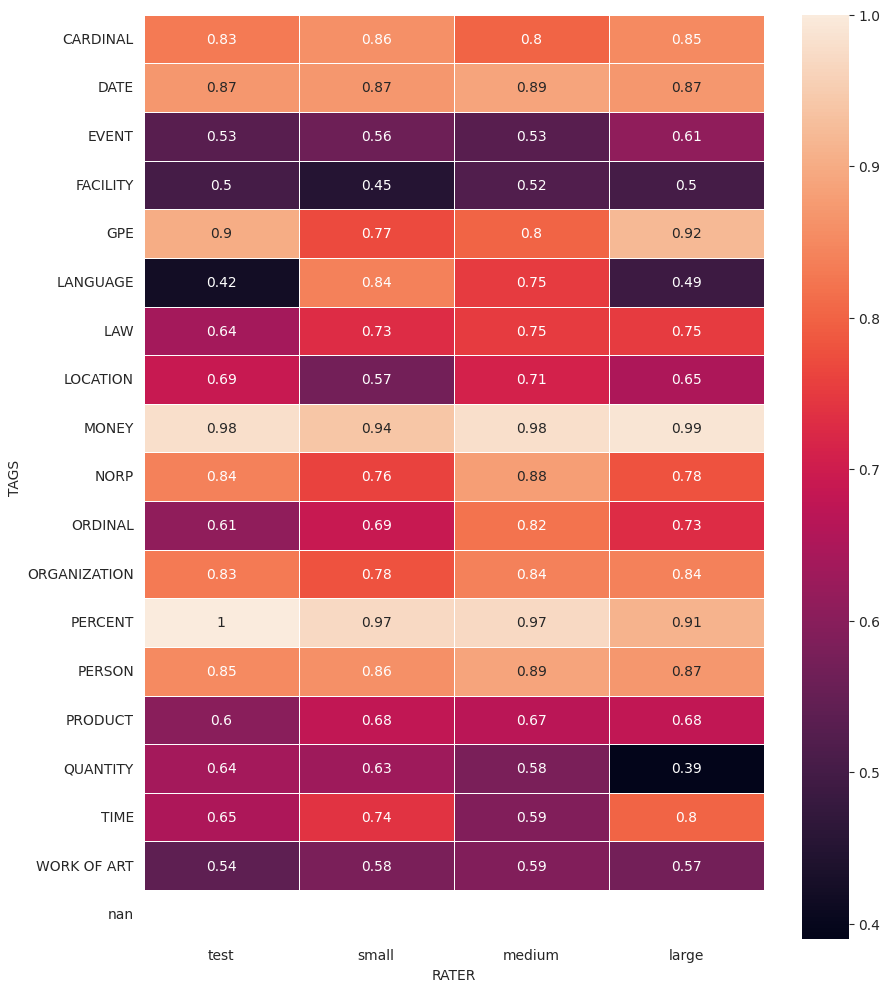

In [19]:
# names = unique_tags
names = list(kappa_df.columns)[:-1]
# tag_f1_dict = {}

# Get F1 Scores by tag and rater
rater_avgs = []
# For all tags (exc)
for tag in unique_tags:
    # Extract f1 scores for tag
    tag_f1 = tag_f1_dict[tag]
    # Get the rater averages
    rater_avgs.append(rater_avg_df(tag_f1)["rater_avg"].tolist()) 
# Store in dataframe and sort
df = pd.DataFrame(rater_avgs, index = unique_tags)

# Sort by index name
df = df.sort_index()
df.columns = names


# Create matrix
print("AVERAGE STRICT F1-SCORE BY TAG AND RATER")
plt.figure(figsize=(10,12))
with sns.axes_style("white"):
    s = sns.heatmap(np.array(df), xticklabels=names, yticklabels=df.index, annot=True, linewidths=0.5, vmax=1.0, cbar=True)
    s.set(ylabel='TAGS', xlabel='RATER');
print(list(df.index))

In [20]:
df = df.drop(columns="test", axis=1)
df


,small,medium,large
CARDINAL,0.86,0.80,0.85
DATE,0.87,0.89,0.87
EVENT,0.56,0.53,0.61
FACILITY,0.45,0.52,0.50
GPE,0.77,0.80,0.92
LANGUAGE,0.84,0.75,0.49
LAW,0.73,0.75,0.75
LOCATION,0.57,0.71,0.65
MONEY,0.94,0.98,0.99
NORP,0.76,0.88,0.78


In [21]:
df.to_csv("../output/ner_models_performance/f1_by_tag.csv")

<Figure size 1200x900 with 0 Axes>

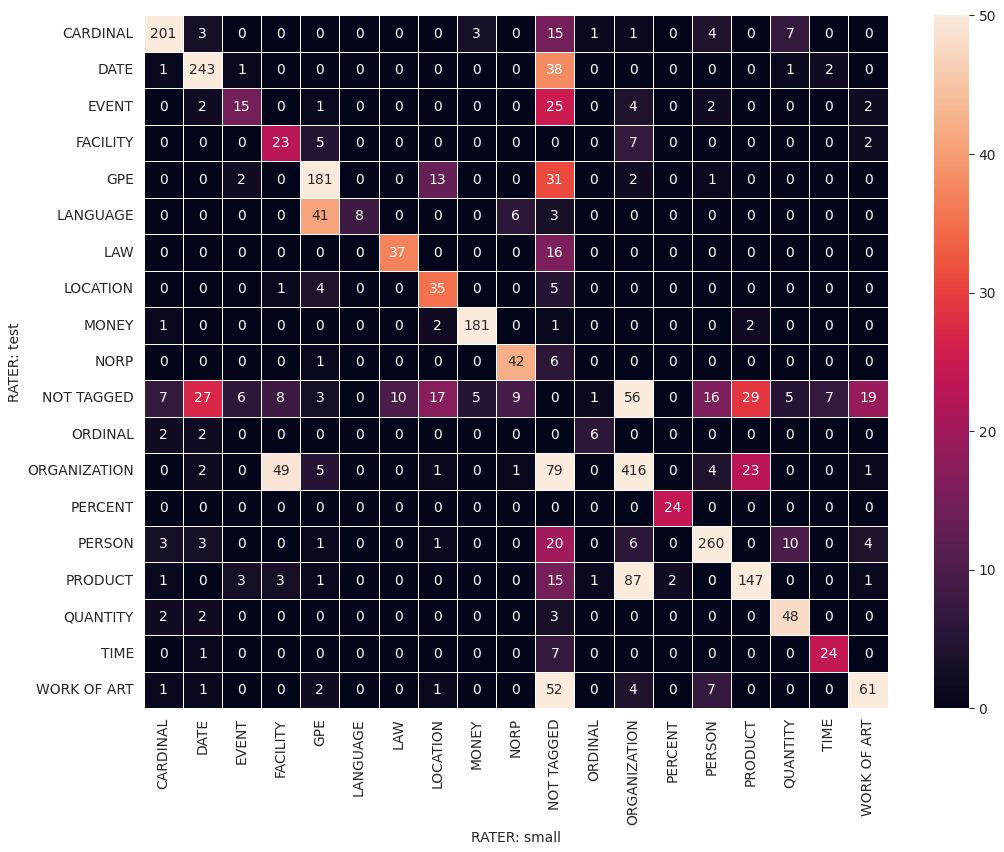

<Figure size 1200x900 with 0 Axes>

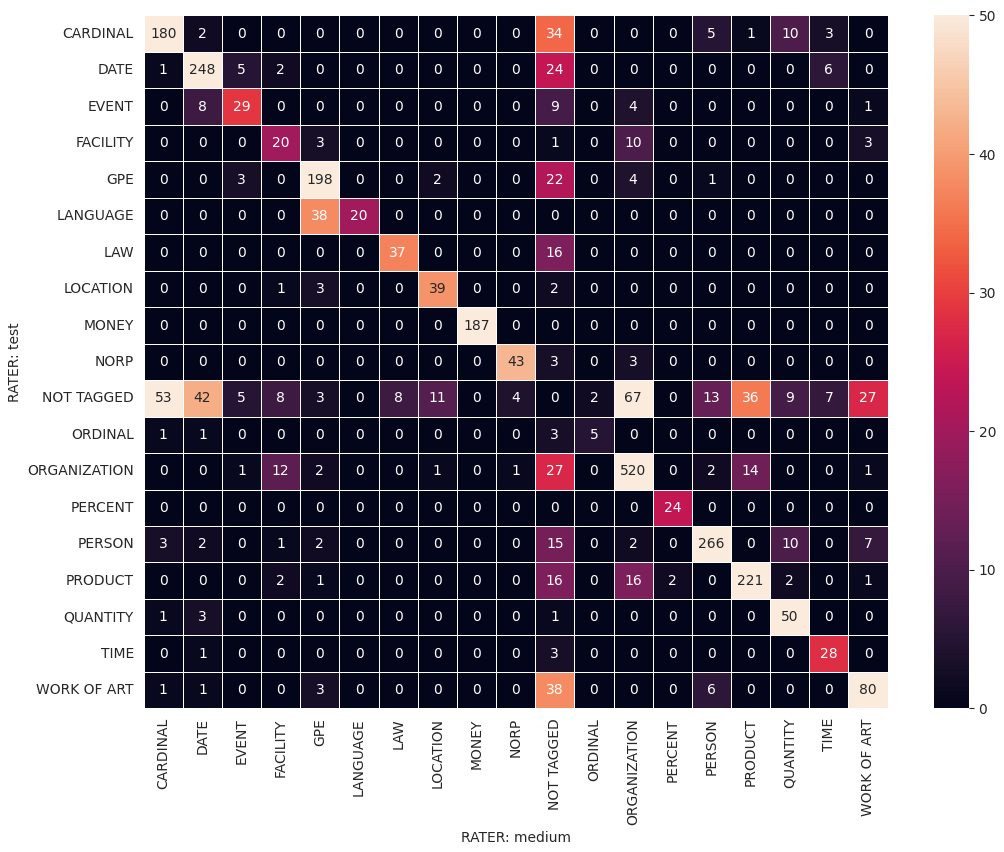

<Figure size 1200x900 with 0 Axes>

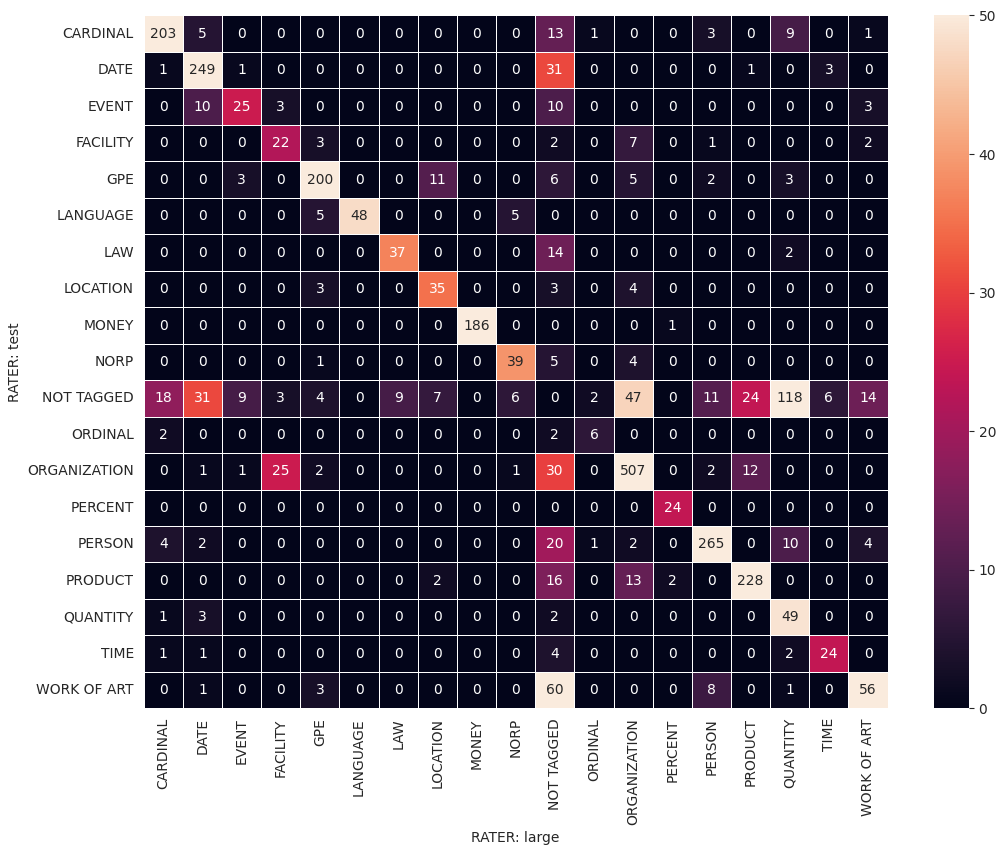

In [22]:
cms = []

for i, size in zip([1, 2, 3], ["_sm","_md","_lg"]):
    
    test = NERdf_list[0].copy()
    labels = sorted(list(set(test.fillna("NOT TAGGED", inplace=False)["spans_label"].tolist())))

    model = NERdf_list[i].copy()

    # Merge data
    pair = pd.merge(test, model, on=["doc", "tokens_text"], suffixes=["_test", size])
    # Drop rows where both have NAs
    pair = pair.dropna(subset=["spans_label_test", f"spans_label{size}"], how="all")
    # Fill np.nan with NA
    pair["spans_label_test"] = pair["spans_label_test"].fillna("NOT TAGGED")
    pair["spans_label_model"] = pair[f"spans_label{size}"].fillna("NOT TAGGED")

    # Create confusion matrix
    # raterA = row(y), raterB = columns(x)
    cm = confusion_matrix(y_true=pair.spans_label_test, y_pred=pair.spans_label_model, labels=labels)
    cms.append(cm)
    # Make plot
    plt.figure(figsize=(12,9))
    plt.figure(figsize=(12,9))
    with sns.axes_style("white"):
        s = sns.heatmap(cm, yticklabels=labels, xticklabels=labels, annot=True, linewidths=.5, vmax=50, cbar=True, fmt="g")
        s.set(ylabel=f'RATER: {NERdf_list[0]["rater_id"][0]}', xlabel=f'RATER: {NERdf_list[i]["rater_id"][0]}')

In [45]:
test = NERdf_list[0].copy()
labels = sorted(list(set(test.fillna("NOT TAGGED", inplace=False)["spans_label"].tolist())))

unique_tags[-6] = "NO TAG"

cm_dfs = []
for cm in cms:
    cm = pd.DataFrame(cm)
    # cm = cm.sort_index(axis=1)
    # cm = cm.sort_index(axis=0)
    cm.columns = labels
    cm.index = labels    
    cm_dfs.append(cm)

In [46]:
cm_dfs[0]

,CARDINAL,DATE,EVENT,FACILITY,GPE,LANGUAGE,LAW,LOCATION,MONEY,NORP,NOT TAGGED,ORDINAL,ORGANIZATION,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK OF ART
CARDINAL,201,3,0,0,0,0,0,0,3,0,15,1,1,0,4,0,7,0,0
DATE,1,243,1,0,0,0,0,0,0,0,38,0,0,0,0,0,1,2,0
EVENT,0,2,15,0,1,0,0,0,0,0,25,0,4,0,2,0,0,0,2
FACILITY,0,0,0,23,5,0,0,0,0,0,0,0,7,0,0,0,0,0,2
GPE,0,0,2,0,181,0,0,13,0,0,31,0,2,0,1,0,0,0,0
LANGUAGE,0,0,0,0,41,8,0,0,0,6,3,0,0,0,0,0,0,0,0
LAW,0,0,0,0,0,0,37,0,0,0,16,0,0,0,0,0,0,0,0
LOCATION,0,0,0,1,4,0,0,35,0,0,5,0,0,0,0,0,0,0,0
MONEY,1,0,0,0,0,0,0,2,181,0,1,0,0,0,0,2,0,0,0
NORP,0,0,0,0,1,0,0,0,0,42,6,0,0,0,0,0,0,0,0


In [47]:
for cm, size in zip(cm_dfs, ["small", "medium", "large"]):
    cm.to_csv(f"../output/ner_models_performance/{size}_confusion_matrix.csv")